# Modular Simulation using Python Generators

This notebook show how to use Python generators for creating system simulation. This technique implements simulation blocks as Python generators, then pieces blocks together to create more complex systems. This is an advanced technique that may be useful in control projects and a convenient alternative to block diagram simulators.

## Simulation using scipy.integrate.odeint()

### Typical Usage

The SciPy library provides a convenient and familiar means of simulating systems modeled by systems of ordinary differential equations.  As demonstrated in other notebooks, the straightforward approach consists of several common steps

1. Initialize graphics and import libraries
2. Fix parameter values
3. Write a function to evaluate RHS of the differential equations
4. Choose initial conditions and time grid
5. Perform the simulation by numerical solution of the differential equations
6. Prepare visualizations and post-processing

Here we demonstrate this approach for a two gravity-drained tanks connected in series with constant inflow.

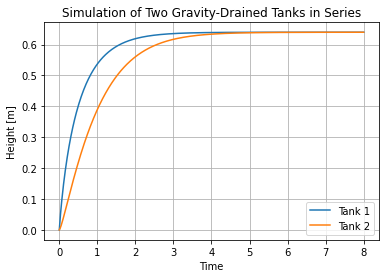

In [1]:
# 1. Initialize graphics and import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# 2. Fix parameter values
A = 0.2
Cv = 0.5
qin = 0.4

# 3. Write a function to evaluate RHS of the differential equations
def deriv(X,t,qin=0):
    h1,h2 = X
    dh1 = (qin - Cv*np.sqrt(h1))/A
    dh2 =  (Cv*np.sqrt(h1) - Cv*np.sqrt(h2))/A 
    return [dh1,dh2]

# 4. Choose initial conditions and time grid
IC = [0,0]
t = np.linspace(0,8,500)

# 5. Perform the simulation by numerical solution of the differential equations
sol = odeint(deriv,IC,t,args=(qin,))

# 6. Prepare visualizations and post-processing
plt.plot(t,sol)
plt.legend(['Tank 1','Tank 2'])
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Simulation of Two Gravity-Drained Tanks in Series')
plt.grid()

## What's Wrong with That?

If direct simulation as outlined above meets the needs of your project, then be satisfied and move on. This is how these tools are intended to be used.

However, as written above, simulation with scipy.integrate.odeint requires you to write a function that calculates the right hand side of a system of differential equations. This can be challenging for complex system. For example, you may have multiple PID controllers, each implementing logic for anti-reset windup. Or you may have components in the process that exhibit hysterisis, time-delay, or other difficult-to-model dynamics. These cases call for a more modular approach to modeling and simulation.

In these cases we'd like to combine the continous time dynamics modeled by differential equations with more complex logic executed at discrete points in the time.

## Python Generators

### Yield Statement

One of the more advanced and often overlooked features of Python is the use of [generators and iterators](http://nvie.com/posts/iterators-vs-generators/) for performing operations on sequences of information. In particular, a generator is a function that returns information to via the `yield` statement rather then the more commonly encountered return statement. When called again, the generator picks right up at the point of the yield statement.

Let's demonsrate this by writing a generator of Fibonacci numbers. This generator returns all Fibonacci numbers less or equal to a given number $n$.

In [2]:
def fib(n):
    i = 0
    j = 1
    while j <= n:
        yield j
        i,j = j,i+j

Here's a typical usage.  What are the Fibonacci numbers less than or equal to 100?

In [3]:
for k in fib(100):
    print(k)

1
1
2
3
5
8
13
21
34
55
89


The generator can also be used inside list comprehensions.

In [4]:
[k for k in fib(1000)]

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]

### Iterators

When called, a generator function creates an intermediate function called an iterator. Here we construct the iterator  and use it within a loop to find the first 10 Fibonacci numbers.

In [5]:
f = fib(500)
for k in range(0,10):
    print(next(f))

1
1
2
3
5
8
13
21
34
55


Using `next` on an iterator returns the next value. 

### Two-way communcation with Generators using Send

So far we have demonstrated the use of `yield` as a way to communicate information from the generator to the calling program. Which is fine if all you need is one-way communication. But for the modular simulation of processes, we need to be able to send information both ways.  A feedback control module, for example, will need to obtain current values of the process variable in order to update its internal state to provide an update of the manipulated variable to calling programm.

Here's the definition of a generator for negative feedback proportional control where the control gain $K_p$ and setpoint $SP$ are specified constants.

In [6]:
def proportionalControl(Kp,SP):
    MV = None
    while True:
        PV = yield MV
        MV = Kp*(SP-PV)

The `yield` statement is now doing double duty.  When first called it sends the value of MV back to the calling program, then stops and waits. It is waiting for the calling program to send a value of PV using the `.send()` method. Execution resumes until the yield statement is encountered again and the new value of MV returned to the calling program.

With this behavior in mind, gettting the generator ready for use is a two step process. The first step is to create an instance (i.e., an iterator).  The second step is to initialize the instance by issuing `.send(None)` command.  This is will halt execution at the first `yield` statement. At that point the generator instance will be ready to go for subsequent simulation.

Here's the initialization of a new instance of proportional control with $K_p = 2.5$ and $SP = 2$.

In [7]:
pc = proportionalControl(2.5,2)
pc.send(None)

This shows it in use.

In [8]:
for PV in range(0,5):
    print(PV, pc.send(PV))

0 5.0
1 2.5
2 0.0
3 -2.5
4 -5.0


You can verify that these results satisfy the proportional control relationship.

## Example Application: Modeling Gravity-Drained Tanks with Python Generators

The first step in using a Python generator for simulation is to write the generator. It will be used to create instances of the dynamical process being modeled by the generator. Parameters should include a sample time `dt` and any other model parameters you choose to specify a particular instance of the process. The yield statement should provide time plus any other relevant process data. The yield statement will produce new values of process inputs valid for the next time step.

### Generator for a Gravity-Drained Tank

In [9]:
# generator for a gravity-drained tank model

def gravtank_generator(dt, A=1, Cv=1, IC=0):
    
    def qout(h):
        return Cv*np.sqrt(float(h))
    
    def deriv(h,t):
        dh = (qin - qout(h))/A
        return dh
    
    h = IC
    t = 0
    while True:
        qin = yield t,qout(h),float(h)
        h = odeint(deriv,h,[t,t+dt])[-1]
        t += dt

### Simulation of a Single Tank with Constant Inflow

Next we show how to use the generator to create a simulation consisting of a single gravity drained tank with constant inflow.

1. Choose a sample time for the simulation.
2. Create instances of the processes to be used in your simulation.
3. The first call to an instance is f.send(None). This will return the initial condition.
4. Subsequent calls to the instance should be f.send(u) where u is variable, tuple, or other data time being passed to the process. The return value will be a tuple contaning the next value of time plus other process data.


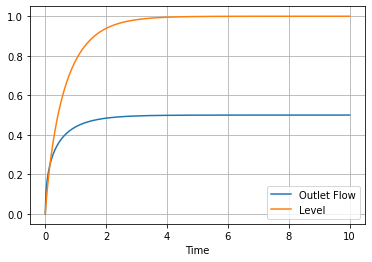

In [10]:
# 1. select sample time
dt = 0.02

# 2. create a process instance
tank = gravtank_generator(dt, A=0.2, Cv=.5)

# 3. get initial condition
y = [tank.send(None)]

# 4. append subsequent states 
y += [tank.send(0.5) for t in np.arange(0,10,dt)]

# 5. extract information into numpy arrays for plotting
t,q,h = np.asarray(y).transpose()
plt.plot(t,q,t,h)
plt.xlabel('Time')
plt.legend(['Outlet Flow','Level'])
plt.grid()

### Simulation of Two Tanks in Series

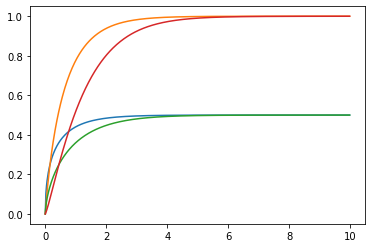

In [11]:
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]

for t in np.arange(dt,10,dt):
    t1,q1,h1 = tank1.send(0.5)
    t2,q2,h2 = tank2.send(q1)
    
    y1.append([t1,q1,h1])
    y2.append([t2,q2,h2])
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()
plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)

### Simulation of Two Tanks in Series with PI Level Control on the Second Tank

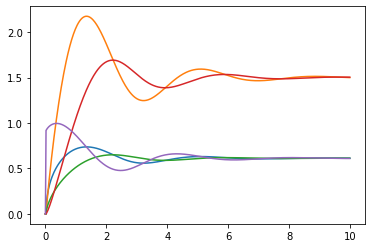

In [12]:
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]

u = 0.0
r2 = 1.5
Kp = .6
Ki = .6
ecurr = 0
ulog = [u]

for t in np.arange(dt,10,dt):
    t1,q1,h1 = tank1.send(u)
    t2,q2,h2 = tank2.send(q1)
    
    eprev,ecurr = ecurr,r2-h2
    u += Kp*(ecurr-eprev) + Ki*ecurr*dt
    u = max(0,min(1,u))
    
    y1.append([t1,q1,h1])
    y2.append([t2,q2,h2])
    ulog.append(u)
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()
plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)
plt.plot(t1,ulog)

### Adding a PI Control Generator

In [13]:
def PI_generator(dt, Kp, Ki, MVmin = 0, MVmax = np.Inf):

    ecurr = 0
    eprev = 0
    t = 0
    u = MVmin
    
    while True:
        r,y,u = yield t,u
        eprev,ecurr = ecurr,r-y
        u += Kp*(ecurr - eprev) + Ki*ecurr*dt
        u = max(MVmin,min(MVmax,u))
        t += dt

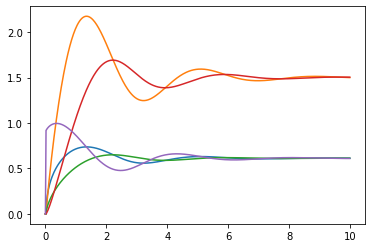

In [14]:
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)
pi = PI_generator(dt, Kp = 0.6, Ki = 0.6, MVmin = 0, MVmax = 1)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]
ulog = [pi.send(None)[1]]

u = 0

for t in np.arange(dt,10,dt):
    t1,q1,h1 = tank1.send(u)
    t2,q2,h2 = tank2.send(q1)
    t3,u = pi.send((r2,h2,u))
    
    y1.append([t,q1,h1])
    y2.append([t,q2,h2])
    ulog.append(u)
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()

plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)
plt.plot(t1,ulog)

### Implementing Cascade Control for Two Tanks in Series with Unmeasured Disturbance

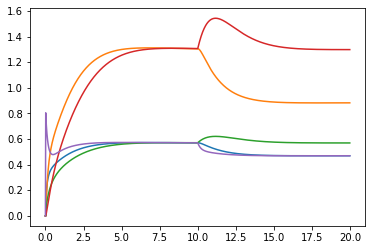

In [15]:
# disturbance function
def d(t):
    if t > 10:
        return 0.1
    else:
        return 0

# simulation
dt = 0.02

tank1 = gravtank_generator(dt, A=0.2, Cv=.5)
tank2 = gravtank_generator(dt, A=0.2, Cv=.5)

# level control for tank 1.  
pi1 = PI_generator(dt, Kp = 1, Ki = 0.6, MVmin = 0, MVmax = 1)

# cascade level control for tank 2. Manipulated variable is the setpoint to pi1
pi2 = PI_generator(dt, Kp = 0.6, Ki = 0.6, MVmin = 0, MVmax = 2)

y1 = [tank1.send(None)]
y2 = [tank2.send(None)]
ulog = [pi1.send(None)[1]]
pi2.send(None)

u = 0
r1 = 0
r2 = 1.3

for t in np.arange(dt,20,dt):
    t1,q1,h1 = tank1.send(u)
    t2,q2,h2 = tank2.send(q1 + d(t))
    t3,r1 = pi2.send((r2,h2,r1))
    t4,u = pi1.send((r1,h1,u))
    
    y1.append([t,q1,h1])
    y2.append([t,q2,h2])
    ulog.append(u)
    
t1,q1,h1 = np.asarray(y1).transpose()
t2,q2,h2 = np.asarray(y2).transpose()
plt.plot(t1,q1,t1,h1)
plt.plot(t2,q2,t2,h2)
plt.plot(t1,ulog)

## Enhancing Modularity with Class Definitions for Process Units

One of the key goals of a modular approach to simulation is to implement process specific behavior within the definitions of the process, and separate from the organization of information flow among units that takes place in the main simulation loop.

Below we define two examples of class definitions demonstrating how this can be done. The class definitions add features for defining names and parameters for instances of each class, and functions to log and plot data gathered in the course of simulations.

### Gravity-Drained Tank Class

In [16]:
class gravtank():
    
    def __init__(self, name='', A=1, Cv=1):
        self.name = name
        self.A = A
        self.Cv = Cv
        self._log = []
        self.qin = 0
    
    def qout(self,h):
        return self.Cv*np.sqrt(float(h))
    
    def deriv(self,h,t):
        dh = (self.qin - self.qout(h))/self.A
        return dh
    
    def plot(self):
        t,qout,h = np.asarray(self._log).transpose()
        plt.plot(t,qout,label=self.name + ' qout')
        plt.plot(t,h,label=self.name + ' h')
        plt.legend()
    
    def generator(self,dt,IC = 0):
        h = IC
        while True:
            t,self.qin = yield self.qout(h),float(h)
            h = odeint(self.deriv,h,[t,t+dt])[-1]
            self._log.append([t,self.qout(h),float(h)])
            t += dt

### PI Controller Class

In [17]:
class PI():
    
    def __init__(self, name='', Kp = 0, Ki = 0, MVmin = 0, MVmax = np.Inf):
        self.name = name
        self.Kp = Kp
        self.Ki = Ki
        self.MVmin = MVmin
        self.MVmax = MVmax
        self._log = []
        
    def plot(self):
        t,r,y,u = np.asarray(self._log).transpose()
        plt.subplot(1,2,1)
        p = plt.plot(t,y,label=self.name + ' PV')
        plt.plot(t,r,'--',color=p[-1].get_color(),label=self.name + ' SP')
        plt.legend()
        plt.title('Process Variable and Setpoint')
        plt.subplot(1,2,2)
        plt.plot(t,u,label=self.name + ' MV')
        plt.title('Manipulated Variable')
        plt.legend()
        plt.tight_layout()
        
    def generator(self,dt):
        ecurr = 0
        eprev = 0
        u = self.MVmin
        while True:
            t,r,y,u = yield u
            self._log.append([t,r,y,u]) 
            eprev,ecurr = ecurr,r-y
            u += Kp*(ecurr - eprev) + Ki*ecurr*dt
            u = max(self.MVmin,min(self.MVmax,u))
            t += dt

### Modular Simulation of Cascade Control for Two Tanks in Series

The following simulation shows how to use the class definitions in a simulation.  Each process instance used in the simulation requires three actions:

1. Create an instance of the process. This is the step at which you can provide an instance name, parameters specific to the process and instance. Methods associated with the instance will be used to examine simulation logs and plot simulation results.

2. Create a generator. A call to the generator function for each process instance creates an associated iterator. A sample time must be specified.

3. An initial call to the iterator with an argument of `None` is needed to advance execution to the first `yield` statement.

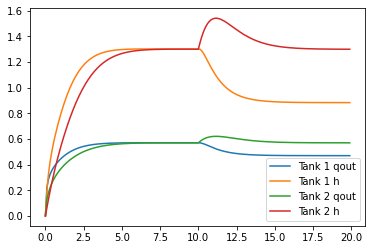

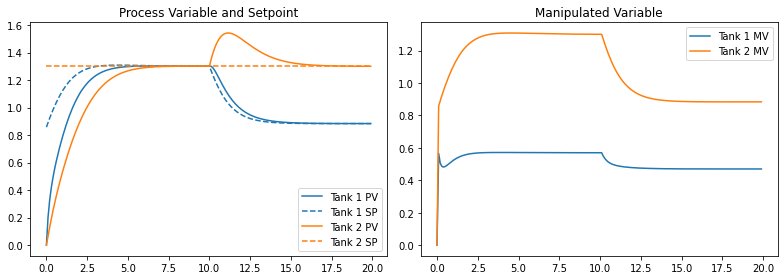

In [18]:
# disturbance function
def d(t):
    if t > 10:
        return 0.1
    else:
        return 0

# sample time
dt = 0.1

# create and initialize tank1
tank1_obj = gravtank(name='Tank 1',A=0.2, Cv=.5)
tank1 = tank1_obj.generator(dt)
tank1.send(None)

# create and initailize tank2
tank2_obj = gravtank(name='Tank 2',A=0.2, Cv=0.5)
tank2 = tank2_obj.generator(dt)
tank2.send(None)

# level control for tank 1. 
pi1_obj = PI('Tank 1',Kp = 1, Ki = 0.6, MVmin = 0, MVmax = 1)
pi1 = pi1_obj.generator(dt)
pi1.send(None)

# cascade level control for tank 2. Manipulated variable is the setpoint to for pi1
pi2_obj = PI('Tank 2',Kp = 0.6, Ki = 0.6, MVmin = 0, MVmax = 2)
pi2 = pi2_obj.generator(dt)
pi2.send(None)

# initial signals
u, r1 = 0, 0

# setpoint for tank 2 level
r2 = 1.3

for t in np.arange(0,20,dt):
    qout1,h1 = tank1.send((t,u))
    qout2,h2 = tank2.send((t,qout1 + d(t)))
    r1 = pi2.send((t,r2,h2,r1))
    u = pi1.send((t,r1,h1,u))    

plt.figure()
tank1_obj.plot()
tank2_obj.plot()

plt.figure(figsize=(11,4))
pi1_obj.plot()
pi2_obj.plot()